# Projet Bootcamp Data Essentials

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
SFPD = pd.read_csv('SFPD_stop_cleaned_data.csv')

C:\Users\Nana\AppData\Local\Temp\ipykernel_13836\1389765928.py:1: DtypeWarning: Columns (27,28,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  SFPD = pd.read_csv('SFPD_stop_cleaned_data.csv')


## DROP COLUMNS WITH CODE

In [40]:
df = SFPD.drop(columns=SFPD.filter(like= "code", axis=1))
df.columns

Index(['doj_record_id', 'person_number', 'agency_ori', 'stop_datetime',
       'duration_of_stop', 'is_stop_response_to_call', 'location', 'district',
       'city', 'perceived_race_ethnicity', 'perceived_gender', 'is_lgbt',
       'perceived_age', 'perceived_age_group', 'had_limited_or_no_english',
       'perceived_or_known_disability', 'reason_for_stop',
       'traffic_violation_type', 'traffic_viol_off_statute',
       'suspicion_off_statute', 'suspicion_sub_type', 'actions_taken',
       'basis_for_search', 'basis_for_property_seizure',
       'type_of_property_seized', 'contraband_or_evidence', 'results_of_stop',
       'longitude', 'latitude', 'supervisor_district',
       'analysis_neighborhoods'],
      dtype='object')

## REGROUP unknowns & UPPER CASE : District

In [41]:
df['district'] = df['district'].replace({'OUT OF SF / UNK': 'Unknown', 'UNK/OUT OF SF': 'Unknown'})
df['district'].fillna('Unknown', inplace=True)

In [42]:
df = df.copy()
df.loc[:,'district'] = df['district'].astype(str).apply(lambda x : x.upper())
df.head(1)

,doj_record_id,person_number,agency_ori,stop_datetime,duration_of_stop,is_stop_response_to_call,location,district,city,perceived_race_ethnicity,...,actions_taken,basis_for_search,basis_for_property_seizure,type_of_property_seized,contraband_or_evidence,results_of_stop,longitude,latitude,supervisor_district,analysis_neighborhoods
0,U3801210950BC4735479,1,CA0380100,2021-04-05 13:10:00,90,True,Terminal 2 departure level,AIRPORT,UNINCORPORATED AREA-SAN MATEO COUNTY,White,...,Person photographed | Search of property was c...,Suspected weapons,Evidence,Firearms | Ammunition | Weapon(s) other than f...,Firearm(s) | Ammunition | Weapon(s) other than...,In-field cite and release,NaN,NaN,0,NaN


## Change "stop_datetime" to DATETIME

In [43]:
df['stop_datetime']=pd.to_datetime(df['stop_datetime'],errors='coerce')
df['stop_year']=df['stop_datetime'].dt.year
df['stop_month']=df['stop_datetime'].dt.month
df['stop_weekday']=df['stop_datetime'].dt.dayofweek
df['stop_hour']=df['stop_datetime'].dt.hour
df['stop_year_month']=df['stop_datetime'].dt.to_period("M")

## NEW COLUMN : TYPE OF RESULTS (category 1 or 0)

In [44]:
df = df.copy()
def type_of_result(x):
    if x == "1" or x == "2" or x == "4":    # pour sélectionner que "No action", "Warning", ou "on site & release"
        x=0
    else: x=1
    return x
df["type_of_results"] = SFPD["results_of_stop_code"].astype(str).apply(type_of_result)

In [45]:
df = df.dropna(subset=['results_of_stop'])

## EDA (see other jupyter notebook)

## Definition TARGET and FEATURES LIST

In [46]:
target='duration_of_stop' 
features_list = ['is_stop_response_to_call', 'district', 'perceived_race_ethnicity', 'perceived_gender', 'is_lgbt',
'perceived_age', 'had_limited_or_no_english', 'perceived_or_known_disability', 'reason_for_stop']

## SPLITTING DATA

In [47]:
X = df.loc[:,features_list]
y = df.loc[:,target]
X.shape, y.shape

((249648, 9), (249648,))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199718, 9), (49930, 9), (199718,), (49930,))

In [49]:
X_train.isna().sum()

is_stop_response_to_call              0
district                              0
perceived_race_ethnicity              0
perceived_gender                      0
is_lgbt                               0
perceived_age                         0
had_limited_or_no_english             0
perceived_or_known_disability    192180
reason_for_stop                     179
dtype: int64

## Dealing with missing values

In [50]:
# Copy X_train to avoid caveats
X_train = X_train.copy()
X_test = X_test.copy()
# No numerical column to impute

# Create categorical imputer 
categorical_imputer = SimpleImputer(strategy="constant", fill_value="Unknown") # We can use strategy="constant"
                                                                                # along with fill_value 
                                                                                # to replace NaN 
                                                                                # by whatever is inside fill_value

# Apply it on concerned column. Careful, we used X[["___"]] on purpose to get a 2D array instead of 1D
X_train[["perceived_or_known_disability","reason_for_stop"]] = categorical_imputer.fit_transform(X_train[["perceived_or_known_disability","reason_for_stop"]])
X_test[["perceived_or_known_disability","reason_for_stop"]] = categorical_imputer.transform(X_test[["perceived_or_known_disability","reason_for_stop"]])
X_train.isnull().any(), X_train.head()

(is_stop_response_to_call         False
 district                         False
 perceived_race_ethnicity         False
 perceived_gender                 False
 is_lgbt                          False
 perceived_age                    False
 had_limited_or_no_english        False
 perceived_or_known_disability    False
 reason_for_stop                  False
 dtype: bool,
         is_stop_response_to_call  district perceived_race_ethnicity  \
 105914                     False   CENTRAL       Hispanic/Latino(a)   
 135571                     False   TARAVAL         Pacific Islander   
 8688                       False  SOUTHERN   Black/African American   
 187600                     False      PARK   Black/African American   
 118984                     False   MISSION       Hispanic/Latino(a)   
 
        perceived_gender  is_lgbt  perceived_age  had_limited_or_no_english  \
 105914             Male    False             25                      False   
 135571             Male    False 

## DATA NORMALIZATION

In [51]:
numeric_features = ['is_stop_response_to_call', 'perceived_age', 'is_lgbt', 'had_limited_or_no_english'] 
numeric_transformer = StandardScaler()


categorical_features = ['district', 'perceived_race_ethnicity', 'perceived_gender', 'perceived_or_known_disability', 'reason_for_stop']
categorical_transformer = OneHotEncoder()


# Apply ColumnTransformer to create a pipeline that will apply the above preprocessing
feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),    
        ('num', numeric_transformer, numeric_features)
        ]
    )

X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test)


In [52]:
X_train

<199718x47 sparse matrix of type '<class 'numpy.float64'>'
	with 1797462 stored elements in Compressed Sparse Row format>

## IMPUTE MODEL

In [53]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [54]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print(f"Train set R2 : {lr.score(X_train,y_train)}")
print(f"Test set R2 : {lr.score(X_test,y_test)}")

Train set R2 : 0.05722444711670149
Test set R2 : 0.06077790002643457


## NEW TARGET : Type of results

In [212]:
target2='type_of_results' 
features_list2 = ['duration_of_stop','is_stop_response_to_call', 'perceived_race_ethnicity', 
                  'perceived_gender', 'perceived_age', 'had_limited_or_no_english', 'reason_for_stop']

## SPLITTING DATA

In [213]:
X2 = df.loc[:,features_list2]
y2 = df.loc[:,target2]
X2.shape, y2.shape

((249648, 7), (249648,))

In [214]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2,random_state=42,stratify=y2)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((199718, 7), (49930, 7), (199718,), (49930,))

In [215]:
X_train2.isna().sum()

duration_of_stop               0
is_stop_response_to_call       0
perceived_race_ethnicity       0
perceived_gender               0
perceived_age                  0
had_limited_or_no_english      0
reason_for_stop              172
dtype: int64

## Dealing with missing values

In [216]:
# Copy X_train to avoid caveats
X_train2 = X_train2.copy()
X_test2 = X_test2.copy()
# No numerical column to impute

# Create categorical imputer 
categorical_imputer = SimpleImputer(strategy="constant", fill_value="Unknown") # We can use strategy="constant"
                                                                                # along with fill_value 
                                                                                # to replace NaN 
                                                                                # by whatever is inside fill_value

# Apply it on concerned column. Careful, we used X[["___"]] on purpose to get a 2D array instead of 1D
X_train2[["reason_for_stop"]] = categorical_imputer.fit_transform(X_train2[["reason_for_stop"]])
X_test2[["reason_for_stop"]] = categorical_imputer.transform(X_test2[["reason_for_stop"]])
X_train2.isnull().any(), X_train2.head()

(duration_of_stop             False
 is_stop_response_to_call     False
 perceived_race_ethnicity     False
 perceived_gender             False
 perceived_age                False
 had_limited_or_no_english    False
 reason_for_stop              False
 dtype: bool,
         duration_of_stop  is_stop_response_to_call perceived_race_ethnicity  \
 111168                 5                     False       Hispanic/Latino(a)   
 26940                 15                      True       Hispanic/Latino(a)   
 53774                  7                     False                    White   
 164604                 5                     False                    Asian   
 33753                 20                     False       Hispanic/Latino(a)   
 
        perceived_gender  perceived_age  had_limited_or_no_english  \
 111168             Male             50                      False   
 26940              Male             40                      False   
 53774              Male             30   

## Normalize data

In [217]:
X_train2.columns

Index(['duration_of_stop', 'is_stop_response_to_call',
       'perceived_race_ethnicity', 'perceived_gender', 'perceived_age',
       'had_limited_or_no_english', 'reason_for_stop'],
      dtype='object')

In [218]:
numeric_features2 = ['duration_of_stop', 'is_stop_response_to_call', 'perceived_age', 'had_limited_or_no_english'] 

categorical_features2 = ['perceived_race_ethnicity', 'perceived_gender', 'reason_for_stop']

# Apply ColumnTransformer to create a pipeline that will apply the above preprocessing
feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features2),    
        ('num', numeric_transformer, numeric_features2)
        ]
    )

X_train2 = feature_encoder.fit_transform(X_train2)
X_test2 = feature_encoder.transform(X_test2)
X_train2


<199718x27 sparse matrix of type '<class 'numpy.float64'>'
	with 1398026 stored elements in Compressed Sparse Row format>

In [219]:
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X_train2,y_train2)

LogisticRegression(max_iter=1000)

In [220]:
print(f"Accuracy for train set : {lr2.score(X_train2,y_train2)}")
print(f"Accuracy for test set : {lr2.score(X_test2,y_test2)}")

Accuracy for train set : 0.5771688080193073
Accuracy for test set : 0.5783897456439014


## Confusion matrix

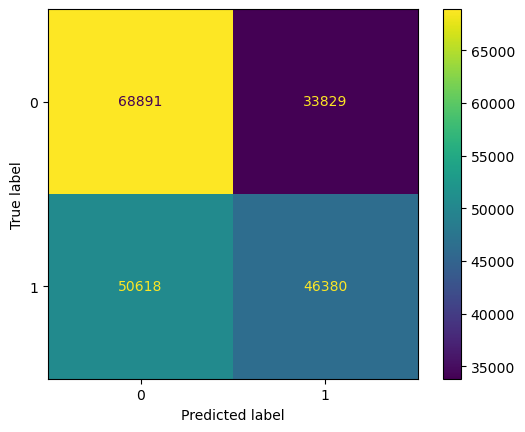

In [221]:
y_train_pred = lr2.predict(X_train2)
y_test_pred = lr2.predict(X_test2)

cm_train = confusion_matrix(y_train2,y_train_pred)
cm_train_display = ConfusionMatrixDisplay.from_predictions(y_train2,y_train_pred)
cm_train_display

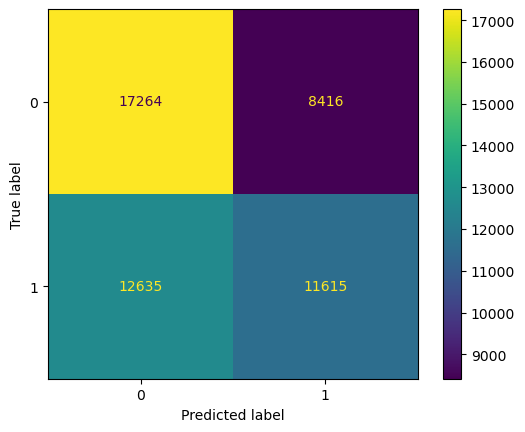

In [222]:
cm_test = confusion_matrix(y_test2,y_test_pred)
cm_test_display = ConfusionMatrixDisplay.from_predictions(y_test2,y_test_pred)
cm_test_display

In [223]:
# other way of doing it : coeff_importance = pd.DataFrame([feature_encoder.get_feature_names_out(), np.abs(lr2.coef_)[0]]).T
                            #coeff_importance.sort_values(by=1,ascending=False)

coeff_importance = pd.DataFrame({"Feature name":feature_encoder.get_feature_names_out(),"Coefficient": np.abs(lr2.coef_)[0]})
coeff_importance.sort_values(by="Coefficient",ascending=False)

,Feature name,Coefficient
22,cat__reason_for_stop_Unknown,3.477318
18,cat__reason_for_stop_Knowledge of outstanding ...,1.834724
14,cat__perceived_gender_Unknown,1.028647
15,cat__reason_for_stop_Consensual encounter resu...,0.801069
7,cat__perceived_race_ethnicity_Unknown,0.504460
17,cat__reason_for_stop_Investigation to determin...,0.404054
13,cat__perceived_gender_Transgender woman/girl,0.338821
10,cat__perceived_gender_Gender Nonconforming,0.326099
1,cat__perceived_race_ethnicity_Black/African Am...,0.309607
19,cat__reason_for_stop_Known to be on parole/pro...,0.303471


## Random Forest Classifier

In [224]:
rdc = RandomForestClassifier(max_depth=4)
rdc.fit(X_train2,y_train2)

RandomForestClassifier(max_depth=4)

In [225]:
rdc.score(X_train2,y_train2)

0.6315905426651579

In [226]:
rdc.score(X_test2,y_test2)

0.6332265171239736

In [227]:

coeff_importance_rfc = pd.DataFrame({"Feature name":feature_encoder.get_feature_names_out(),"Coefficient": rdc.feature_importances_})
coeff_importance_rfc.sort_values(by="Coefficient",ascending=False)

,Feature name,Coefficient
23,num__duration_of_stop,0.515607
18,cat__reason_for_stop_Knowledge of outstanding ...,0.138643
1,cat__perceived_race_ethnicity_Black/African Am...,0.087042
25,num__perceived_age,0.059109
20,cat__reason_for_stop_Reasonable suspicion that...,0.042301
21,cat__reason_for_stop_Traffic violation,0.040180
0,cat__perceived_race_ethnicity_Asian,0.030926
24,num__is_stop_response_to_call,0.019252
8,cat__perceived_race_ethnicity_White,0.015274
15,cat__reason_for_stop_Consensual encounter resu...,0.009588


## Decision Tree Classifier

In [228]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train2,y_train2)

DecisionTreeClassifier()

In [229]:
dtc.score(X_train2,y_train2)

0.7322875254108293

In [230]:
dtc.score(X_test2,y_test2)

0.624694572401362

## Plot Decision Tree (from random forest classifier)

In [231]:
from sklearn import tree

[Text(0.45535714285714285, 0.9, 'cat__reason_for_stop_Knowledge of outstanding arrest warrant/wanted person <= 0.5\ngini = 0.5\nsamples = 126284\nvalue = [102556, 97162]\nclass = Action'),
 Text(0.19642857142857142, 0.7, 'cat__perceived_race_ethnicity_Asian <= 0.5\ngini = 0.499\nsamples = 123507\nvalue = [101738, 93614]\nclass = Action'),
 Text(0.10714285714285714, 0.5, 'cat__perceived_gender_Unknown <= 0.5\ngini = 0.498\nsamples = 109916\nvalue = [92168, 81663]\nclass = Action'),
 Text(0.07142857142857142, 0.3, 'cat__perceived_race_ethnicity_Black/African American <= 0.5\ngini = 0.498\nsamples = 109842\nvalue = [92038, 81663]\nclass = Action'),
 Text(0.03571428571428571, 0.1, 'gini = 0.5\nsamples = 79981\nvalue = [63794, 62577]\nclass = Action'),
 Text(0.10714285714285714, 0.1, 'gini = 0.481\nsamples = 29861\nvalue = [28244, 19086]\nclass = Action'),
 Text(0.14285714285714285, 0.3, 'gini = 0.0\nsamples = 74\nvalue = [130, 0]\nclass = Action'),
 Text(0.2857142857142857, 0.5, 'cat__reas

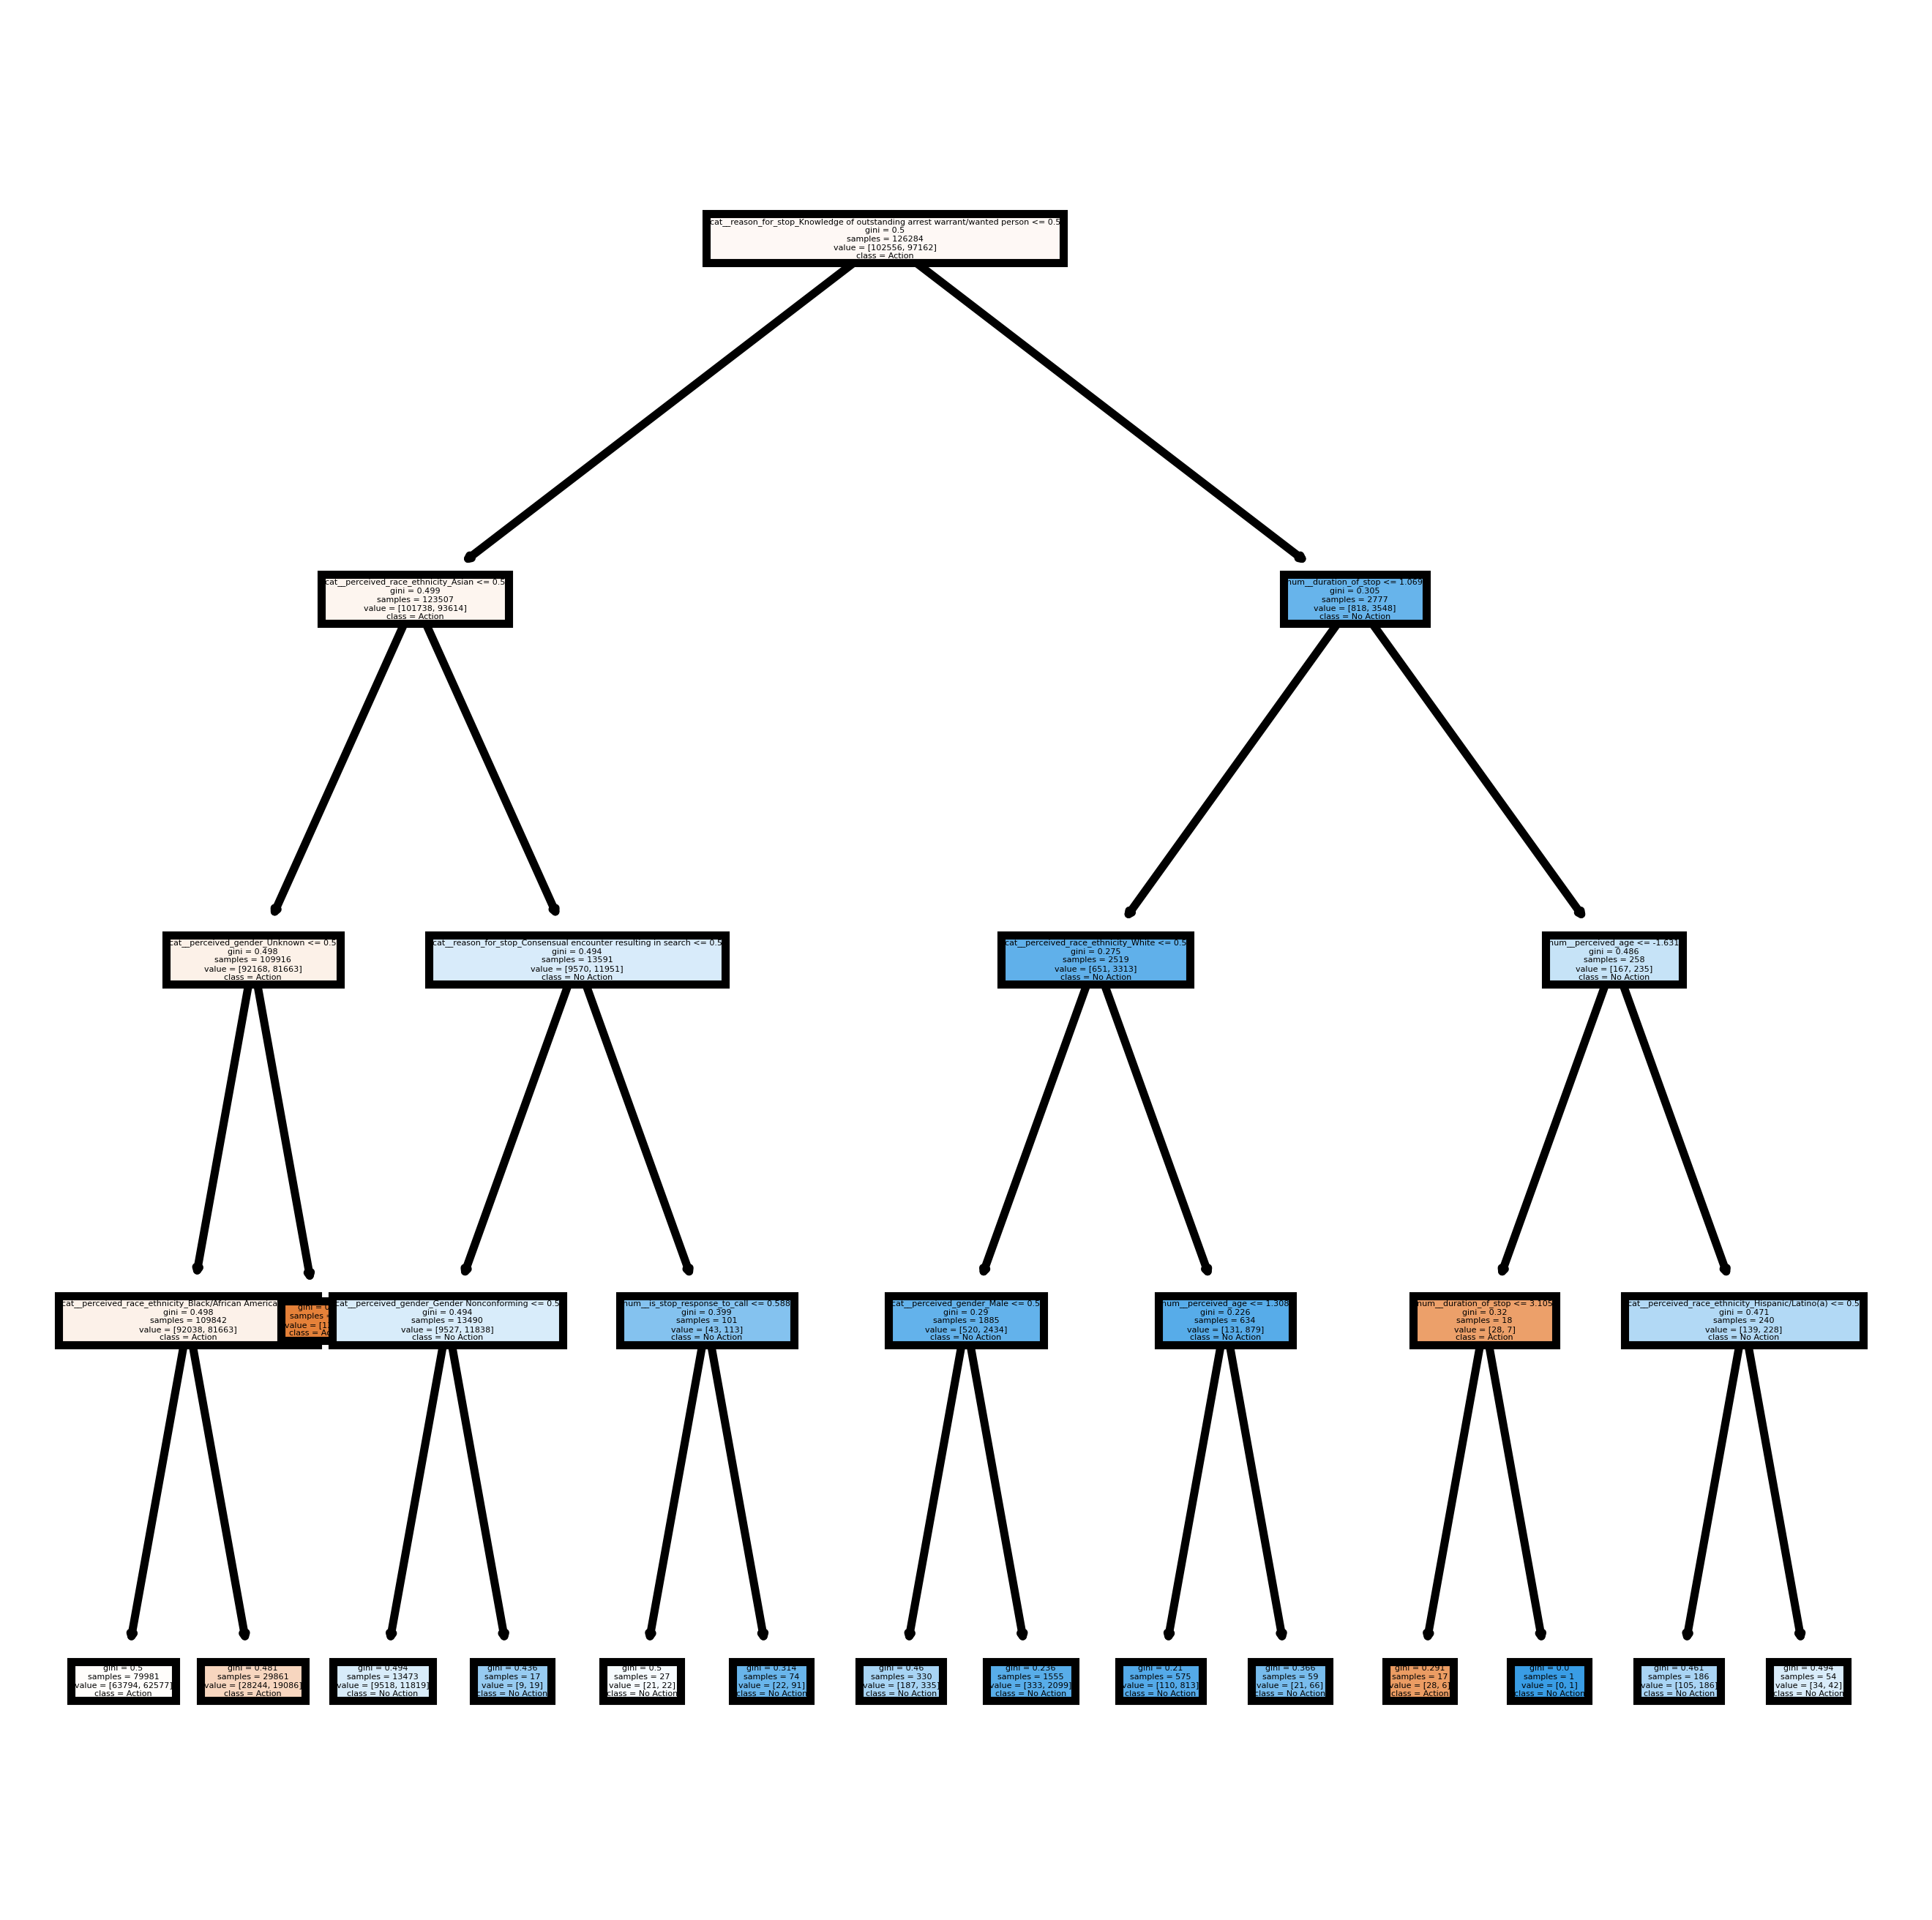

In [232]:
fig, axes = plt.subplots(nrows= 1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(rdc.estimators_[0],
               feature_names = feature_encoder.get_feature_names_out(),
               class_names = ["Action","No Action"],
               filled = True)

## Heat Map of Features correlation

In [233]:
corr = df.corr()

C:\Users\Nana\AppData\Local\Temp\ipykernel_16044\658818363.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

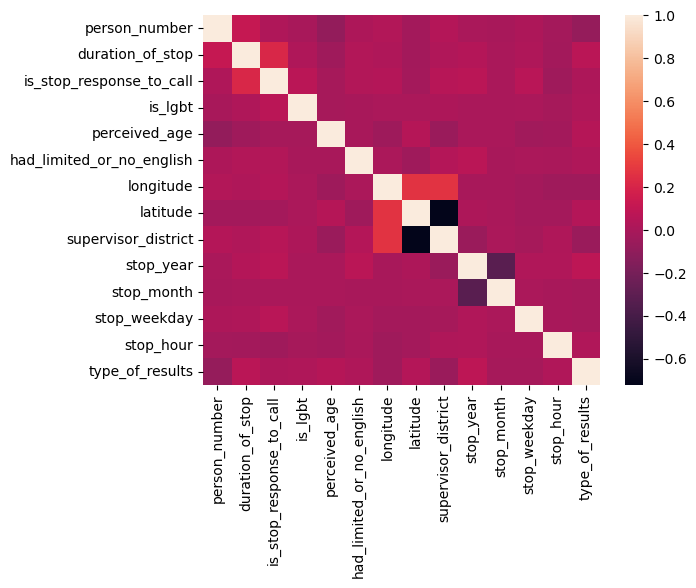

In [234]:
sns.heatmap(corr)